C:\Users\Hello\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3867 - loss: 1.0778 - val_accuracy: 0.6237 - val_loss: 0.9159
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5445 - loss: 0.9223 - val_accuracy: 0.6237 - val_loss: 0.8181
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6315 - loss: 0.8330 - val_accuracy: 0.7312 - val_loss: 0.7148
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6545 - loss: 0.7585 - val_accuracy: 0.8065 - val_loss: 0.6291
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7446 - loss: 0.6505 - val_accuracy: 0.8387 - val_loss: 0.5510
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7651 - loss: 0.6103 - val_accuracy: 0.8387 - val_loss: 0.4782
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8173 - loss: 0.5136 - val_accuracy: 0.8495 - val_loss: 0.4147
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8310 - loss: 0.4471 - val_accuracy: 0.8710 - val_loss

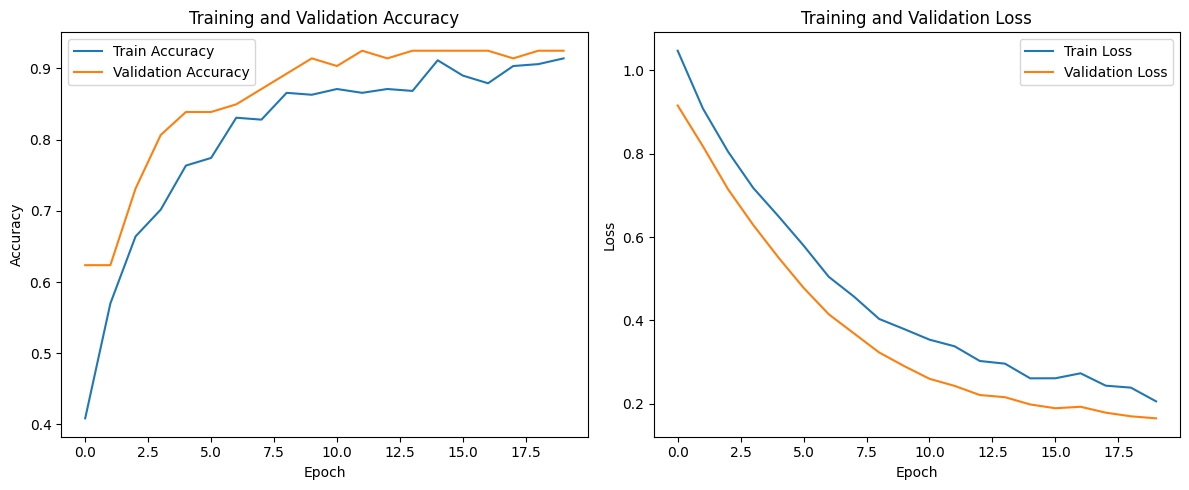


Test Accuracy: 0.9145

Classification Report:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
                  precision    recall  f1-score   support

   Bearing_fault       0.92      0.92      0.92        39
    Normal_state       0.88      0.90      0.89        39
Unbalance_weight       0.95      0.92      0.94        39

        accuracy                           0.91       117
       macro avg       0.92      0.91      0.91       117
    weighted avg       0.92      0.91      0.91       117



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
df = pd.read_csv('optical_flow_features.csv')

# Define feature columns
numerical_cols = [
    'flow_mean', 'flow_std', 'flow_max',
    'orientation_mean', 'orientation_std',
    'temporal_grad_mean', 'temporal_grad_std', 'temporal_grad_max',
    'dominant_freq', 'flow_entropy', 'motion_consistency',
    'total_frames', 'actual_fps'
]

categorical_cols = ['view']

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Prepare features and target
X = df.drop(columns=['state', 'video_name', 'segment_duration', 'is_overlap'])
y = df['state']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=20,  
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, model.predict(X_test_preprocessed).argmax(axis=1),
                            target_names=le.classes_))